# Compute apparent terms from HR data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functions import *

In [4]:
inputs = xr.open_mfdataset(
    './inputs_hr.nc', chunks={'time': 10}, combine='by_coords'
).transpose('time', 'mid_levels', 'lat', 'lon')
outputs = xr.open_mfdataset(
    './outputs_hr.nc', chunks={'time': 10}, combine='by_coords'
).transpose('time', 'mid_levels', 'lat', 'lon')

In [5]:
inputs

<xarray.Dataset>
Dimensions:                            (lat: 128, lon: 256, mid_levels: 10, time: 1440)
Coordinates:
  * time                               (time) datetime64[ns] 2000-01-01T00:30:00 ... 2000-06-28T21:30:00
Dimensions without coordinates: lat, lon, mid_levels
Data variables:
    surface_upward_latent_heat_flux    (time, lat, lon) float64 dask.array<shape=(1440, 128, 256), chunksize=(10, 128, 256)>
    surface_temperature                (time, lat, lon) float64 dask.array<shape=(1440, 128, 256), chunksize=(10, 128, 256)>
    air_pressure                       (time, mid_levels, lat, lon) float64 dask.array<shape=(1440, 10, 128, 256), chunksize=(10, 10, 128, 256)>
    specific_humidity                  (time, mid_levels, lat, lon) float64 dask.array<shape=(1440, 10, 128, 256), chunksize=(10, 10, 128, 256)>
    surface_upward_sensible_heat_flux  (time, lat, lon) float64 dask.array<shape=(1440, 128, 256), chunksize=(10, 128, 256)>
    eastward_wind                      (tim

## Coarse-grain data

In this easy example, we just need to average over every 4 by 4 boxes

In [6]:
inputs_coarse = inputs.coarsen(lat=4, lon=4).mean()

In [11]:
outputs_coarse = outputs.coarsen(lat=4, lon=4).mean()

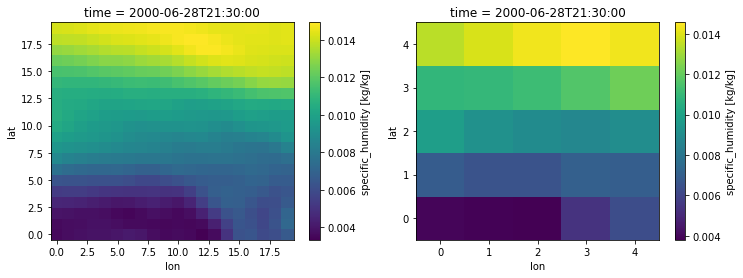

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
inputs.specific_humidity.isel(
    mid_levels=0, time=-1, lat=slice(40, 60), lon=slice(0, 20)
).plot(ax=ax1)
inputs_coarse.specific_humidity.isel(
    mid_levels=0, time=-1, lat=slice(40//4, 60//4), lon=slice(0, 20//4)
).plot(ax=ax2)

## Compute derivatives

### Compute distance between points in meters

In [13]:
from geopy import distance

In [14]:
with open('./state.pkl', 'rb') as f:
    my_state = pickle.load(f)

In [15]:
tmp_model = MyModel(nx=64*4, ny=32*4, dt_seconds=900.,
                    input_save_fn='./inputs_hr.nc', 
                    output_save_fn='./outputs_hr.nc')

In [16]:
hr_template = tmp_model.state

In [17]:
lr_lat = my_state['latitude'][:, 0]
lr_lon = my_state['longitude'][0]
hr_lat = hr_template['latitude'][:, 0]
hr_lon = hr_template['longitude'][0]

In [18]:
lr_lat.diff('lat')

<xarray.DataArray (lat: 31)>
array([-5.491808, -5.524239, -5.531564, -5.534341, -5.535682, -5.536428,
       -5.536884, -5.537181, -5.537383, -5.537524, -5.537625, -5.537697,
       -5.537748, -5.537781, -5.5378  , -5.537806, -5.5378  , -5.537781,
       -5.537748, -5.537697, -5.537625, -5.537524, -5.537383, -5.537181,
       -5.536884, -5.536428, -5.535682, -5.534341, -5.531564, -5.524239,
       -5.491808])
Dimensions without coordinates: lat

In [19]:
hr_lat.coarsen(lat=4).mean().diff('lat')

<xarray.DataArray (lat: 31)>
array([-5.595345, -5.601921, -5.6026  , -5.602822, -5.602922, -5.602975,
       -5.603007, -5.603028, -5.603042, -5.603051, -5.603058, -5.603063,
       -5.603066, -5.603069, -5.60307 , -5.60307 , -5.60307 , -5.603069,
       -5.603066, -5.603063, -5.603058, -5.603051, -5.603042, -5.603028,
       -5.603007, -5.602975, -5.602922, -5.602822, -5.6026  , -5.601921,
       -5.595345])
Dimensions without coordinates: lat

In [20]:
coarse_lat = hr_lat.coarsen(lat=4).mean()
coarse_lon = hr_lon.coarsen(lon=4).mean()

In [21]:
len(coarse_lat), len(coarse_lon)

(32, 64)

In [22]:
coarse_lat_mid = (coarse_lat[1:] + coarse_lat[:-1]).values / 2

In [23]:
coarse_lat_mid

array([ 84.03990209,  78.44126933,  72.83900902,  67.23629823,
        61.63342664,  56.03047812,  50.42748669,  44.82446895,
        39.22143402,  33.61838737,  28.01533251,  22.41227183,
        16.80920705,  11.20613947,   5.60307015,   0.        ,
        -5.60307015, -11.20613947, -16.80920705, -22.41227183,
       -28.01533251, -33.61838737, -39.22143402, -44.82446895,
       -50.42748669, -56.03047812, -61.63342664, -67.23629823,
       -72.83900902, -78.44126933, -84.03990209])

In [24]:
coarse_lat_mid2 = np.array(
   [coarse_lat_mid[0] - coarse_lat.diff('lat')[0]] + 
    list(coarse_lat_mid) + 
    [coarse_lat_mid[-1] + coarse_lat.diff('lat')[-1]]
)

In [25]:
coarse_lat_mid2

array([ 89.63524704,  84.03990209,  78.44126933,  72.83900902,
        67.23629823,  61.63342664,  56.03047812,  50.42748669,
        44.82446895,  39.22143402,  33.61838737,  28.01533251,
        22.41227183,  16.80920705,  11.20613947,   5.60307015,
         0.        ,  -5.60307015, -11.20613947, -16.80920705,
       -22.41227183, -28.01533251, -33.61838737, -39.22143402,
       -44.82446895, -50.42748669, -56.03047812, -61.63342664,
       -67.23629823, -72.83900902, -78.44126933, -84.03990209,
       -89.63524704])

In [26]:
dlat_m = [distance.distance(ll1, ll2).m for (ll1, ll2) in zip(
    zip(coarse_lat_mid2[1:], [0]*len(coarse_lat_mid2[1:])),
    zip(coarse_lat_mid2[:-1], [0]*len(coarse_lat_mid2[1:]))
)]

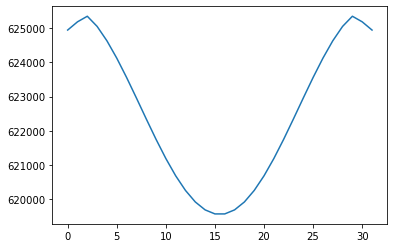

In [27]:
plt.plot(dlat_m)

In [28]:
dlon_m = [distance.distance(ll1, ll2).m for (ll1, ll2) in zip(
    zip(coarse_lat, 
        [coarse_lon[0]]*len(coarse_lat)),
    zip(coarse_lat,
        [coarse_lon[1]]*len(coarse_lat))
)]

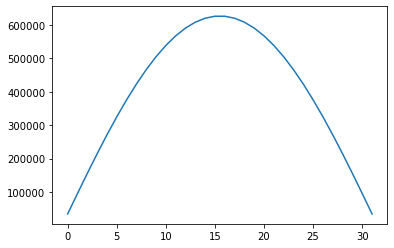

In [29]:
plt.plot(dlon_m)

### Differentiation data

In [50]:
inputs_coarse_dx = inputs_coarse[input_vars].differentiate('lon', 2)
inputs_coarse_dy = inputs_coarse[input_vars].differentiate('lat', 2)

## Compute to metric units

In [51]:
len(dlon_m), len(dlat_m)

(32, 32)

In [52]:
inputs_coarse_dx[input_vars]

<xarray.Dataset>
Dimensions:            (lat: 32, lon: 64, mid_levels: 10, time: 1440)
Coordinates:
  * time               (time) datetime64[ns] 2000-01-01T00:30:00 ... 2000-06-28T21:30:00
Dimensions without coordinates: lat, lon, mid_levels
Data variables:
    air_temperature    (time, mid_levels, lat, lon) float64 dask.array<shape=(1440, 10, 32, 64), chunksize=(10, 10, 32, 64)>
    specific_humidity  (time, mid_levels, lat, lon) float64 dask.array<shape=(1440, 10, 32, 64), chunksize=(10, 10, 32, 64)>
    eastward_wind      (time, mid_levels, lat, lon) float64 dask.array<shape=(1440, 10, 32, 64), chunksize=(10, 10, 32, 64)>
    northward_wind     (time, mid_levels, lat, lon) float64 dask.array<shape=(1440, 10, 32, 64), chunksize=(10, 10, 32, 64)>
    air_pressure       (time, mid_levels, lat, lon) float64 dask.array<shape=(1440, 10, 32, 64), chunksize=(10, 10, 32, 64)>

In [53]:
inputs_coarse_dx /= np.array(dlon_m)[None, None, :, None]

In [54]:
inputs_coarse_dy /= np.array(dlat_m)[None, None, :, None]

## Compute time tendency

In [55]:
dt = 3*60*60/2; dt

5400.0

In [56]:
inputs_coarse_dt = inputs_coarse.differentiate('time', 2, datetime_unit='s')

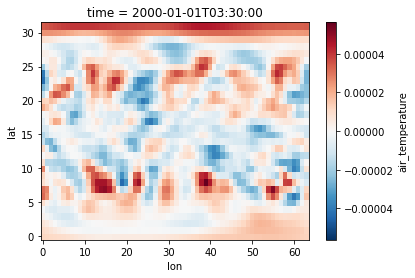

In [57]:
inputs_coarse_dt.air_temperature.isel(time=1, mid_levels=5).plot()

## Compute advection term

In [58]:
advection = (
    inputs_coarse.eastward_wind * inputs_coarse_dx + 
    inputs_coarse.northward_wind * inputs_coarse_dy
)

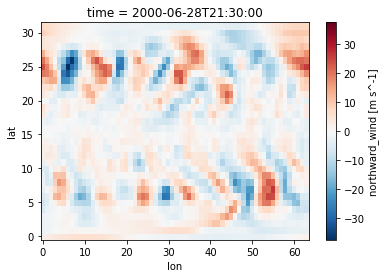

In [59]:
inputs_coarse.northward_wind.isel(time=-1, mid_levels=5).plot()

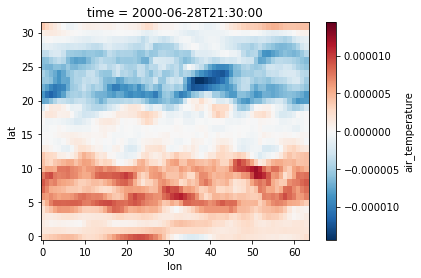

In [60]:
inputs_coarse_dy.air_temperature.isel(time=-1, mid_levels=5).plot()

## Apparent terms

In [61]:
apparent = inputs_coarse_dt + advection

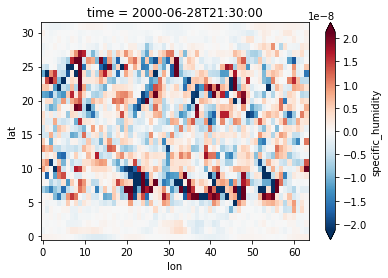

In [75]:
inputs_coarse_dt.specific_humidity.isel(time=-1, mid_levels=3).plot(robust=True)

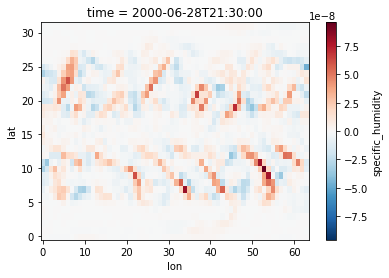

In [63]:
advection.specific_humidity.isel(time=-1, mid_levels=3).plot()

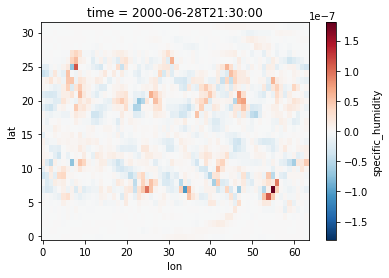

In [77]:
apparent.specific_humidity.isel(time=-1, mid_levels=2).plot()

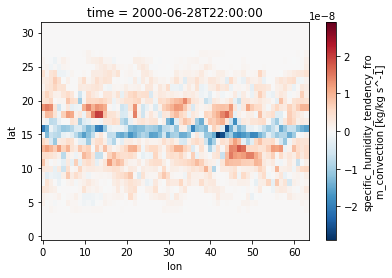

In [76]:
outputs_coarse.specific_humidity_tendency_from_convection.isel(time=-1, mid_levels=2).plot()

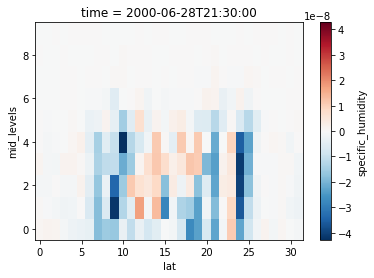

In [78]:
apparent.specific_humidity.isel(time=-1, lon=0).plot()

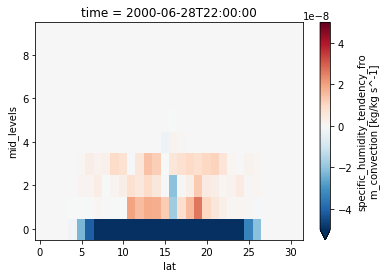

In [83]:
outputs_coarse.specific_humidity_tendency_from_convection.isel(time=-1, lon=0).plot(vmin=-0.5e-7, vmax=0.5e-7, cmap='RdBu_r')

In [123]:
my_state.keys()

dict_keys(['specific_humidity', 'air_temperature', 'air_pressure', 'air_pressure_on_interface_levels', 'surface_air_pressure', 'eastward_wind', 'northward_wind', 'divergence_of_wind', 'atmosphere_relative_vorticity', 'atmosphere_hybrid_sigma_pressure_a_coordinate_on_interface_levels', 'atmosphere_hybrid_sigma_pressure_b_coordinate_on_interface_levels', 'time', 'longitude', 'latitude', 'height_on_ice_interface_levels', 'surface_geopotential', 'surface_temperature', 'surface_specific_humidity', 'longwave_optical_depth_on_interface_levels', 'cloud_base_mass_flux', 'stratiform_precipitation_rate', 'surface_upward_latent_heat_flux', 'surface_upward_sensible_heat_flux', 'downwelling_longwave_flux_in_air', 'upwelling_longwave_flux_in_air', 'longwave_heating_rate', 'convective_state', 'convective_precipitation_rate', 'convective_downdraft_velocity_scale', 'convective_downdraft_temperature_scale', 'convective_downdraft_specific_humidity_scale', 'atmosphere_convective_available_potential_energy'

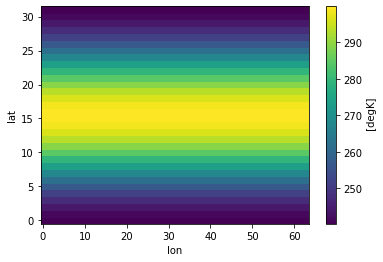

In [129]:
my_state['surface_temperature'].plot()

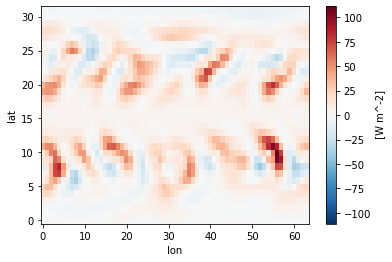

In [130]:
my_state['surface_upward_sensible_heat_flux'].plot()

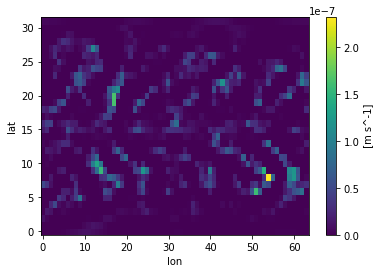

In [131]:
my_state['stratiform_precipitation_rate'].plot()

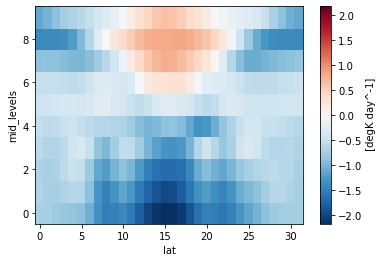

In [125]:
my_state['longwave_heating_rate'].isel(lon=0).plot()

In [126]:
radiation = climt.GrayLongwaveRadiation()

In [127]:
radiation.input_properties

{'longwave_optical_depth_on_interface_levels': {'dims': ['interface_levels',
   '*'],
  'units': 'dimensionless',
  'alias': 'tau'},
 'air_temperature': {'dims': ['mid_levels', '*'],
  'units': 'degK',
  'alias': 'sl'},
 'surface_temperature': {'dims': ['*'], 'units': 'degK', 'alias': 'T_surface'},
 'air_pressure': {'dims': ['mid_levels', '*'], 'units': 'Pa', 'alias': 'p'},
 'air_pressure_on_interface_levels': {'dims': ['interface_levels', '*'],
  'units': 'Pa',
  'alias': 'p_interface'}}

In [128]:
radiation.tendency_properties

{'air_temperature': {'units': 'degK s^-1'}}